# Рекомендация тарифов

Представлены данные оператора мобильной связи «Мегалайн». Выявлено, что многие клиенты пользуются архивными тарифами. 

Заказчику нужна система для анализа поведения клиентов и предложения пользователям нового тарифа: «Смарт» или «Ультра».

Для анализа предоставлены данные о поведении клиентов, которые уже перешли на эти тарифы. 
Требуется построить модель для задачи классификации, которая выберет подходящий тариф.

Метрика - *accuracy*, baseline - 0.75.

<a id='Назад к оглавлению'></a>

### План Исследования

#### Поделим наще исследование на несколько частей.

#### Часть 1. Анализ общей информации
<a href='#Анализ общей информации'> 1.1 Загрузка библиотек, чтение данных и анализ общей информации</a>

<a href='#1.2 Разбиение данных на выборки'> 1.2 Разбиение данных на выборки</a>

#### Часть 2. Подбор модели машинного обучения
<a href='#2.1 Запуск моделей с параметрами по умолчанию'> 2.1 Запуск моделей с параметрами по умолчанию</a>

<a href='#2.2 Подбор параметров моделей'> 2.2 Подбор параметров моделей</a>

<a href='#2.3 Проверка качества лучшей модели на тестовой выборке'> 2.3 Проверка качества лучшей модели на тестовой выборке</a>

<a href='#2.4 Проверка модели на вменяемость'> 2.4 Проверка модели на вменяемость</a>

#### Часть. 3 Общий вывод
<a href='#Часть. 3 Общий вывод'> Часть. 3 Общий вывод</a>

<a id='Анализ общей информации'></a>

### Часть 1. Анализ и предподготовка данных. 

#### 1.1 Загрузка библиотек, чтение данных и анализ общей информации

In [1]:
# # Для анализа данных будем использовать библиотеку pandas_profiling.
# # Установим библиотеку и изменим версию pandas c которой profiling работает стабильно
# !pip install pandas_profiling==1.4.1
# !pip install pandas==0.25.3

In [2]:
# Импортируем библиотеки, с помощью которых будем обрабатывать данные
import numpy as np
import pandas as pd
import pandas_profiling
import time

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

# Настройки для печати нескольких выводов данных в одной ячейке
from IPython.core.interactiveshell import InteractiveShell

# для отключения FutureWarning
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Прочитаем данные из файла и запишем в переменную df
df = pd.read_csv('/datasets/users_behavior.csv')

In [4]:
# Используем метод info для определения типов данных признаков
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [5]:
# Запусим библиотеку pandas_profiling и посмотрим как выглядят статистики 
pandas_profiling.ProfileReport(df)

Number of variables,5
Number of observations,3214
Total Missing (%),0.0%
Total size in memory,125.7 KiB
Average record size in memory,40.0 B
Numeric,3
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,1


Инструмент pandas_profiling позволяет изучить основную информацию о значениях и статистиках по признакам. Автоматический анализатор позволяет быстро получить информацию о типах данных, распределениях, наличиях пропусков и дублей в наборе данных. Так же можно увидеть информацию о корреляции между признаками или признаками и целевой переменной. Данный инструмент не позволяет ответить на все вопросы о наших данных, но помогает довольно быстро оценить основные проблемы, присутствующие в данных и определиться с инструментами для более детального анализа.

Анализ текущих данных в pandas_profiling показал, что данные достаточно "чистые" - отсутствуют пропуски, дубли, распределения выглядят соразмерно типу значения. Но, инструмент подсветил нам наличие высокой корреляции (0.98) между признаками `mintes` и `calls`, что отражено как на корреляционных матрицах, так и непосредственно в анализе признака `mintes`. Требуется более внимательно изучить вопрос мультиколлинеарности в рассматриваемом наборе данных.

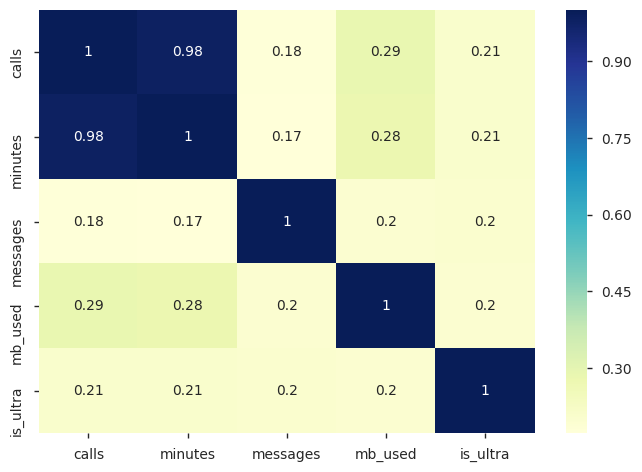

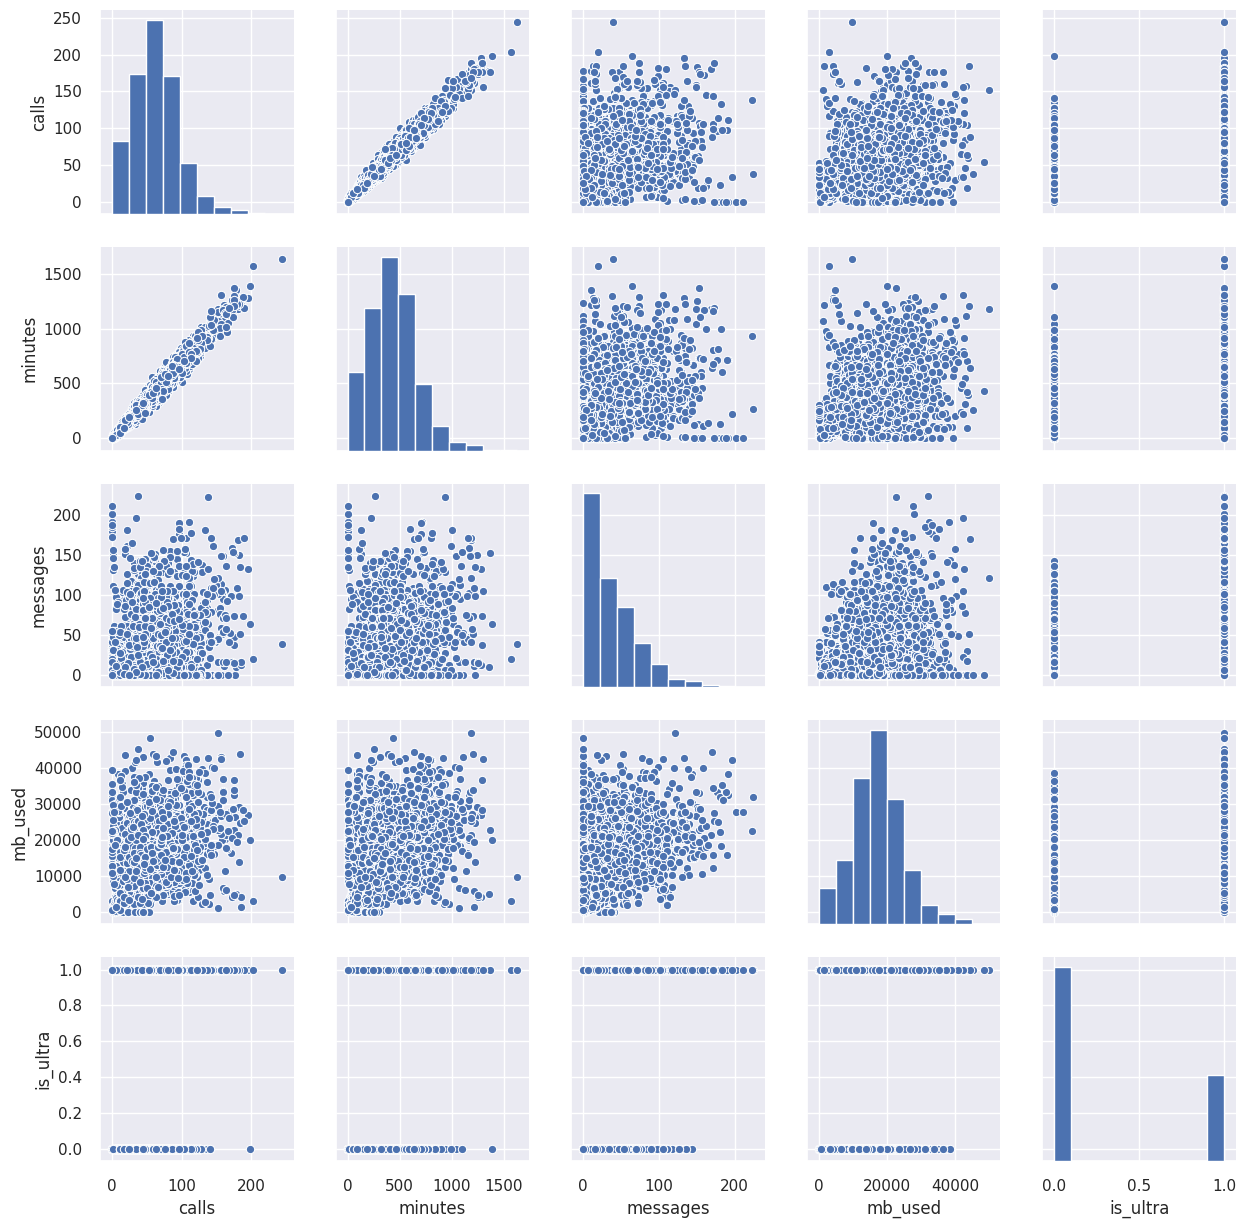

In [6]:
# Проверим корреляцию между признаками и построим график типа scatterplot
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu")

sns.set() 
sns.pairplot(df, size = 2.5)
plt.show();

#### Вывод

Посмотрим какая информация содержится в колонках:

- `сalls` — количество звонков,  
- `minutes` — суммарная длительность звонков в минутах,  
- `messages` — количество sms-сообщений,  
- `mb_used` — израсходованный интернет-трафик в Мб,  
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).  


Преобразование типов не требуется, пропуски отсутствуют, диапозоны значений соответствуют логике данных.

Выявлено наличие высокой корреляции (0.98) между признаками `mintes` и `calls`. Данная особеность может негативно отразиться на качестве работы моделей машинного обучения, т.к. модель будет уделять данным признакам гораздо больше внимания чем остальным. Требуется удалить один из коррелирующих признаков, например `calls`, т.к. тариф в большей степени характеризуется количеством использованных минут, а не количеством звонков. 

Можно приступать к следующему этапу

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='1.2 Разбиение данных на выборки'></a>

#### 1.2 Разбиение данных на выборки

In [7]:
# посмотрим на распределение данных по нашей целевой переменной — is_ultra
df['is_ultra'].value_counts()

# посмотрим распределение классов в долях
print('Класс Smart {:.0%}'.format(1-df['is_ultra'].mean()))
print('Класс Ultra {:.0%}'.format(df['is_ultra'].mean()))

Класс Smart 69%
Класс Ultra 31%


In [8]:
# в переменную features поместим датасет удалив колонку is_ultra. Одновремено удалим колонку calls
# отделим от датасета колонку is_ultra с целевой переменной и поместим её в переменную target
features = df.drop(['is_ultra', 'calls'], axis=1)
target = df['is_ultra']

In [9]:
# поделим данные на обучающую, валидационную и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=42)

In [10]:
# Посмотрим на размер получившихся выборок
for name, data in {'features_train': features_train, 
                   'features_test':features_test, 
                   'target_train':target_train, 
                   'target_test':target_test}.items():
    print("Размер выборки  %s:"  % (name),(data.shape))
    

Размер выборки  features_train: (2410, 3)
Размер выборки  features_test: (804, 3)
Размер выборки  target_train: (2410,)
Размер выборки  target_test: (804,)


#### Вывод

Разделили датасет на обучающую и тестовую выборки. В тестовую выборку определяем 25% от общего набора данных, оставшиеся 75% будут использованны для обучения. Такое разбиение обусловлено логикой тренировки моделей машинного обучения - набор данных на котором модель будет обучатся должен содержать достаточное количество данных для выявления зависимостей и апроксимации решения. Т.к. для проверки качества работы модели у нас нет дополнительного набора данных, мы должны это учесть и поэтому мы выделяем часть данных для имитации запуска работы модели на данных, которые она ранее не видела. Принято разделять данные в соотношении 80/20, 70/30, 75/25. Последний вариант выглядит наиболее оптимальным для поставленной задачи.

В рамках исследования выявлен факт несбалансированной выборки - значений одного из прогнозируемых классов значительно больше. 
Данный факт может отрицательно сказаться на результат использования метрики accuracy - данная метрика отражает долю правильных ответов. Высокий показатель данной метрики на несбалансированной выборке может получиться только лишь благодаря тому, что превалирует один из классов и мы его верно прогнозируем. В постановке задачи от нас требуется использовать метрику accuracy, но правильнее было бы либо решить проблему балансировки классов, либо воспользоваться другими метриками (precision, recall, balanced accuracy)

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='2.1 Запуск моделей с параметрами по умолчанию'></a>

### Часть 2. Подбор модели машинного обучения

#### 2.1 Запуск моделей с параметрами по умолчанию

In [11]:
# Напишем функцию которая принимает на вход набор данных, вектор правильных ответов и инициализированную модель.
# Данные разделяются на обучающий и валидационный наборы в соотношении 75/25. 
# Модель запускается в цикле 10 раз и производится расчёт метрики accuracy.
# Функция возвращает усредненное значение метрики по результату 10 итераций.
def Model(data, target, modeltype, modelstr):
    
    kFold = 10
    seed = 42
    roc_auc_value = 0
    acc = 0
    

    for fold in range(kFold):
        X_train, X_val, Y_train, Y_val = train_test_split(data, 
                                                          target, 
                                                          test_size=.25, 
                                                          random_state= fold * seed)

        
        model = modeltype.fit(X_train, Y_train)
        prediction = modeltype.predict(X_val)

        acc += accuracy_score(Y_val, prediction)
        
        
    print("Accuracy для %s: %f"  % (modelstr,(acc / kFold)))

In [12]:
# Осуществим вызов функции Model в цикле для последовательного запуска моделей:
# DecisionTreeClassifier, LogisticRegression, RandomForestClassifier
model_dict = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=12345),
    'RandomForestClassifier': RandomForestClassifier()}

for modelstr, modeltype in model_dict.items():
    start_time = time.time()
    Model(features_train, target_train, modeltype, modelstr)
    print("Время, затраченное для построения модели в сек: ", (time.time() - start_time))
    print("------------------------------------------------------")

Accuracy для DecisionTreeClassifier: 0.719071
Время, затраченное для построения модели в сек:  0.1432335376739502
------------------------------------------------------
Accuracy для LogisticRegression: 0.702156
Время, затраченное для построения модели в сек:  0.07840251922607422
------------------------------------------------------
Accuracy для RandomForestClassifier: 0.785406
Время, затраченное для построения модели в сек:  0.3923799991607666
------------------------------------------------------


#### Вывод

Для анализа было выбрано четыре модели машинного обучения: Решающее дерево, Логистическая регрессия, Случайный лес. Все алгоритмы запускались для решения классификационной задачи.  
Наиболее быстрой, но меньшей по метрике оказалась LogisticRegression, дольше всех, но с лучшим значением метрики отработал RandomForestClassifier.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='2.2 Подбор параметров моделей'></a>

#### 2.2 Подбор параметров моделей

In [13]:
# Для каждой из рассматриваемых моделей запустим алгоритм перебора параметров GridSearchCV
# Данные разделяются на обучающий и валидационный наборы в соотношении 75/25. 
# Каждая модель запускается в цикле 4 раза по методу перекрестной проверки

random_state = 12345

model = {'dtc': DecisionTreeClassifier(random_state=random_state),
         'lr': LogisticRegression(random_state=random_state),
         'rfc': RandomForestClassifier(random_state=random_state)}

param_grid = {'dtc': {'max_depth': list(range(5, 16, 5)), 'max_features': range(1,4), 'min_samples_leaf':range(5,16,5)},
              'lr': {'C': [0.001, 1, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
              'rfc': {'max_depth': list(range(5, 16, 5)),
                      'n_estimators': list(range(10, 201, 50))}}

for model_key in ['dtc', 'lr', 'rfc']:
    
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    gs = GridSearchCV(model[model_key], param_grid[model_key], scoring='accuracy', cv=kf, return_train_score=False)

    gs.fit(features_train, target_train)

    print("Accuracy на обучающей выборке для %s: {:.3f}".format(accuracy_score(target_train, gs.predict(features_train))) % model_key)
    print("------------------------------------------------------")

Accuracy на обучающей выборке для dtc: 0.803
------------------------------------------------------
Accuracy на обучающей выборке для lr: 0.746
------------------------------------------------------
Accuracy на обучающей выборке для rfc: 0.880
------------------------------------------------------


In [14]:
# Посмотрим подробнее лучшие параметры победившей модели
res = (pd.DataFrame({
        "mean_test_score": gs.cv_results_["mean_test_score"],
        "mean_fit_time": gs.cv_results_["mean_fit_time"],
        "params": gs.cv_results_["params"]})
      .join(pd.io.json.json_normalize(gs.cv_results_["params"]).add_prefix("param_")))

res.sort_values('mean_test_score', ascending=False).head(20)

print('Индекс лучшего элемента в cv_results_: {:.3f}'.format(gs.best_index_))
print('Наилучшие значения гиперпараметров: {}'.format(gs.best_params_))
print('Наилучшее значение Accuracy: {:.3f}'.format(gs.best_score_))

Индекс лучшего элемента в cv_results_: 6.000
Наилучшие значения гиперпараметров: {'max_depth': 10, 'n_estimators': 110}
Наилучшее значение Accuracy: 0.800


In [15]:
# Выведем наилучшие значения найденные с помощью GridSearchCV
InteractiveShell.ast_node_interactivity = "all"

print("Accuracy на обучающей выборке для %s: {:.3f}".format(accuracy_score(target_train, gs.predict(features_train))) % model_key)
print('Лучший "estimator" для предсказаний: ', gs.best_estimator_)

Accuracy на обучающей выборке для rfc: 0.880
Лучший "estimator" для предсказаний:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)


#### Вывод

Произведен подбор параметров с помощью алгоритма GridSearchCV для всех рассматриваемых моделей (Решающее дерево, Логистическая регрессия, Случайный лес). 
Данный алгоритм позволяет в автоматическом режиме проверить диапазоны гиперпараметров для нескольких моделей с применением метода перекрестной проверки. 

Лучший результат по метрике accuracy показала модель Решающее дерево - RandomForestClassifier.  
Лучший результат на обучающей выборке после подбора параметров составил 0.880

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='2.3 Проверка качества лучшей модели на тестовой выборке'></a>

#### 2.3 Проверка качества лучшей модели на тестовой выборке

In [16]:
# Запустим предсказание модели отобранной с помощью алгоритма GridSearchCV на тестовом наборе данных 
# Посчитаем значение метрики Accuracy и Balanced accuracy
predict_test = gs.best_estimator_.predict(features_test)
accuracy_test = accuracy_score(target_test, predict_test)
balanced_accuracy_test = balanced_accuracy_score(target_test, predict_test)
print("Accuracy на тестовой выборке: ", accuracy_test)
print("Balanced accuracy на тестовой выборке: ", balanced_accuracy_test)

Accuracy на тестовой выборке:  0.8171641791044776
Balanced accuracy на тестовой выборке:  0.7335098307846114


#### Вывод

Запуск модели RandomForestClassifier на тестовой выборке показал значение метрики accuracy равное 0.817, что выше, чем требуемый baseline. Однако, как было подсвечено выше, показатель данной метрики для несбалансированной выборки может дать ошибочное представление о качетве модели. Проверив тестовые данные более корректной метрикой мы в этом убедились - значение метрики Balanced accuracy на тестовой выборке составило 0.734, что ниже требуемого baseline.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='2.4 Проверка модели на вменяемость'></a>

#### 2.4 Проверка модели на вменяемость

In [17]:
# Создадим предсказания, где тариф предсказывается случайным образом (1 - Ultra, 0 - Smart)
predictions_test_random = pd.Series(np.random.randint(2,size=len(features_test)), index=features_test.index)

In [18]:
# Доля правильных ответов для случайной модели для тестовой выборки
accuracy_random = accuracy_score(target_test, predictions_test_random)
print('Доля правильных ответов для случайной модели для тестовой выборки:',accuracy_random)

Доля правильных ответов для случайной модели для тестовой выборки: 0.5161691542288557


In [19]:
# Проверяем на адекватность модель случайного леса
if accuracy_test <= accuracy_random:
    print('Модель с рандомными значениями показала лучший результат:',accuracy_test,'<=',accuracy_random)
else:
    print('Модель случайного леса показала лучший результат:',accuracy_test,'>',accuracy_random)

Модель случайного леса показала лучший результат: 0.8171641791044776 > 0.5161691542288557


#### Вывод

Проверили модель случайного леса на вменяемость:
Проверка производилась по сравнению метрик accuracy для рандомной модели и модели случайного леса.
    
Рандомная модель показала accuracy ~ 0.5  
Значение метрики accuracy для модели случаного леса выше, из чего можно сделать вывод, что данная модель вменяема.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>

<a id='Часть. 3 Общий вывод'></a>

### Часть. 3 Общий вывод

Проанализированы данные о поведении клиентов, которые перешли на тарифы. 
Построено 3 классификационные модели для прогноза подходящего клиенту тарифа: Решающее дерево, Логистическая регрессия, Случайный лес.  

Среди рассмотренных моделей, лучший результат по метрике accuracy показала модель Решающее дерево - RandomForestClassifier.  
Лучший результат на обучающей выборке после подбора параметров составил 0.880  
Значение метрики на тестовой выборке составил:  0.817  
Проверена альтернативная метрика для несбаласированных данных (как в нашем случае) - Balanced accuracy. На тестовой выборке получился результат 0.734, что является более правдопобобным применительно к предоставленным данным. В дальнейшем, для более качественного анализа предлагается соблюдать баланс классов при подготовке данных для анализа.

Результирующая модель случайного леса сравнили с рандомной моделью - значение метрики для модели случаного леса выше значения метрики для рандомной модели, что говорит о качестве разработанной модели.

<a href='#Назад к оглавлению'> Назад к оглавлению</a>